In [1]:
import simi

import itertools
import json
import random
import re
import zipfile

import nltk.data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sentence_transformers import evaluation, losses, models, InputExample, SentenceTransformer, util as stu
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import torch
from tqdm.auto import tqdm, trange
tqdm.pandas()

ARXIV_ZIP = "arxiv dump/arxiv-metadata-oai-snapshot-version111.json.zip"
DUMP_JSON = "arxiv-metadata-oai-snapshot.json"

RANDOM_STATE = 1

random.seed(RANDOM_STATE)

2024-01-02 11:17:12.708292: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
def join_text(title, abstract):
    title = title.strip("").rstrip(".")
    t = nltk.data.load('tokenizers/punkt/PY3/english.pickle')
    ss = [sn.replace("\n", " ") for sn in t.tokenize(re.sub(r"\s+", " ", "{}. {}".format(title, abstract)))]
    try:
        return " ".join(ss)
    except Exception as e:
        return ""

In [3]:
%%time
dfs = []
with zipfile.ZipFile(ARXIV_ZIP) as za:
    with tqdm(total=za.getinfo(DUMP_JSON).file_size, unit="b", unit_divisor=1024, unit_scale=True, desc=DUMP_JSON) as pb:
        with za.open(DUMP_JSON) as f:       
            for l in f:
                j = json.loads(l)
                dfs.append(pd.DataFrame([[j["title"], j["abstract"], j["categories"], j["doi"]]], columns=["title", "abstract", "categories", "doi"]))
                pb.update(len(l))
df_fresh = pd.concat(dfs, ignore_index=True).reset_index(drop=True)
df_fresh["categories"] = df_fresh["categories"].map(lambda c: tuple(c.split()))

arxiv-metadata-oai-snapshot.json:   0%|          | 0.00/3.37G [00:00<?, ?b/s]

CPU times: user 7min 52s, sys: 10.1 s, total: 8min 3s
Wall time: 8min


In [4]:
math_cats = sorted([c for c in set(itertools.chain.from_iterable(df_fresh["categories"])) if c.startswith("math") or c.startswith("stat")])
df_fresh = df_fresh[df_fresh["categories"].map(lambda c: len(set(c) & set(math_cats)) > 0)]

df_fresh["text"] = df_fresh.progress_apply(lambda r: join_text(r["title"], r["abstract"]), axis=1)
df_fresh = df_fresh[df_fresh["text"] != ""]

#df = df[["title", "categories"]]
df_fresh = df_fresh[["title", "abstract", "categories"]]

df_fresh = df_fresh[df_fresh.categories.map(lambda c: len(c)==1)]
df_fresh = df_fresh[["title", "abstract"]]
len(df_fresh)

  0%|          | 0/650485 [00:00<?, ?it/s]

272292

In [5]:
%%time
df = pd.read_pickle("arxiv-full-text-embeddings-single-class-multi.pkl")
print(len(df))
df.sample(5)

272292
CPU times: user 15.1 s, sys: 10.5 s, total: 25.6 s
Wall time: 25.6 s


,text,categories,embedding (Bert+MP),embedding (Bert+MP+class-arx),embedding (Bert+MP+class-zbm),embedding (Mathbert+CLS),embedding (Mathbert+MP+class-arx),embedding (Mathbert+MP+class-zbm),embedding (Bert+TSDAE+MP),embedding (Bert+TSDAE+MP+class-arx),...,embedding (SBert+ret_class-arx),embedding (SBert+ret_class-zbm),embedding (Specter 2+MP),embedding (Specter 2.0+MP+class-arx),embedding (Specter 2.0+MP+class-zbm),embedding (Specter 2+MP+class-zbm+anch-arx),embedding (Specter 2+MP+anch-arx+class-arx+class-zbm),embedding (SGPT),embedding (SGPT+class-zbm),embedding (SGPT+class-arx)
68049,Uniquely determined uniform probability on the...,"(math.PR,)","[-0.22952631, 0.030581241, 0.30536026, -0.2147...","[0.19173138, 0.28852123, -0.68162507, -0.27106...","[0.48331594, 0.87109613, -0.088084124, -0.0073...","[-0.020000672, 0.024827631, 0.017208688, -0.03...","[0.55113184, -0.23633322, 0.74411243, 1.297612...","[0.5194377, -0.89713794, -0.2121454, -0.890146...","[0.13241488, -0.03346429, 0.044905037, 0.07020...","[0.04800567, 0.24217696, -0.34815595, -0.73591...",...,"[0.058110572, -0.06253108, 0.081139974, 0.0174...","[-0.00742613, -0.047051776, -0.012914245, -0.0...","[0.5276258, 0.2946987, 0.06516706, 0.10866989,...","[-1.0657026, 2.0173924, 0.11431563, -0.6400839...","[0.49069476, 0.8277614, -0.7273409, -0.4923512...","[-0.2677986, 0.46044585, -0.041323565, -1.9930...","[-0.42570668, 0.44847825, 1.8686519, -0.880446...","[-0.7507138, 1.0962132, -0.58522, -0.47487092,...","[0.37363353, 0.40652934, -0.7210833, 0.7447302...","[-0.04941025, -1.2378826, -0.46302015, 1.54576..."
196213,Global estimation and scenario-based projectio...,"(stat.AP,)","[-0.46946454, -0.055494763, 0.15277499, -0.074...","[-0.106669575, -0.24781235, -0.88685423, -0.17...","[-0.09411666, -0.32020164, -0.42804328, -0.873...","[0.026955374, 0.036259484, 0.029138045, 0.0297...","[0.6287878, -0.60221934, -0.6914961, 1.2722259...","[-0.615466, 0.21806124, 0.2761057, 0.6733616, ...","[-0.121525936, 0.018205162, 0.0717394, -0.1554...","[0.621099, -0.6634175, -1.2202208, -0.16226184...",...,"[-0.034704365, -0.08722481, -0.019805344, 0.01...","[0.015029513, -0.027662508, -0.009019609, 0.01...","[0.558096, 0.15985794, -0.39572993, -0.0583454...","[0.67685264, -1.0278822, -0.49735564, -0.07113...","[0.35998094, 0.5316801, -1.9750075, -0.2306221...","[1.2148293, -0.9851126, -1.4403088, -0.8392070...","[1.163341, -0.27211857, -1.4153719, 0.61024255...","[1.3432908, -0.14411473, -0.29217154, -0.82065...","[0.32798997, 0.3039382, -0.797511, 0.42399088,...","[2.30322, -1.1711943, -2.3337152, 1.1094453, 1..."
146254,Average number of zeros and mixed symplectic v...,"(math.DG,)","[-0.20558964, 0.00016615064, 0.49258882, -0.12...","[-0.5203948, -0.29737958, 0.9990329, 0.4616001...","[0.3510328, 0.48498383, 0.63871545, 0.08812944...","[-0.03045611, 0.023609769, 0.022473603, -0.022...","[0.63372445, 0.6770415, 0.5193964, 0.47794074,...","[0.3027682, -0.4908208, 0.6580445, -1.1969266,...","[0.23087107, 0.012188614, 0.4503112, 0.1034023...","[-1.186505, 0.032838974, 1.4101714, 0.04622987...",...,"[0.029727826, -0.027091978, -0.012699489, 0.03...","[0.0238634, 0.035005927, -0.041637994, -0.0222...","[0.058632854, 0.45061356, -0.20690542, 0.33314...","[-1.416952, 1.8070186, -1.2485266, -0.54117596...","[0.059259143, 0.99239045, 1.2522985, 1.0441236...","[-1.3035246, -0.6583367, -1.2797866, -0.830500...","[-1.1135318, 0.04249462, -1.7313472, 1.6197132...","[0.82780665, -0.89704835, 0.36930588, -1.58197...","[0.3569101, -1.4302737, -0.22660448, 0.2459249...","[-3.2676308, -2.5332057, 0.13056354, 0.0051756..."
95835,Applications of Bourgain-Brezis inequalities t...,"(math.AP,)","[-0.4208042, -0.100593455, 0.3929792, -0.21072...","[-0.4505022, -0.6709537, 0.66761565, 0.6397604...","[-0.10284625, 0.07885316, 1.7000074, -0.002773...","[-0.03550178, 0.041842986, 0.042080857, 0.0066...","[0.08917675, 0.7599781, 0.4058961, 0.46994916,...","[0.57063067, 0.31425452, -0.40730667, 0.351784...","[

In [6]:
df_join = df.join(df_fresh.reset_index(drop=True), how="left")
print(len(df_join))
df_join.sample(5)

272292


,text,categories,embedding (Bert+MP),embedding (Bert+MP+class-arx),embedding (Bert+MP+class-zbm),embedding (Mathbert+CLS),embedding (Mathbert+MP+class-arx),embedding (Mathbert+MP+class-zbm),embedding (Bert+TSDAE+MP),embedding (Bert+TSDAE+MP+class-arx),...,embedding (Specter 2+MP),embedding (Specter 2.0+MP+class-arx),embedding (Specter 2.0+MP+class-zbm),embedding (Specter 2+MP+class-zbm+anch-arx),embedding (Specter 2+MP+anch-arx+class-arx+class-zbm),embedding (SGPT),embedding (SGPT+class-zbm),embedding (SGPT+class-arx),title,abstract
172354,Integral representations for the Hartman--Wats...,"(math.PR,)","[-0.29610255, -0.12201702, 0.14425462, -0.3588...","[0.03770944, -0.03342493, -0.5672817, -0.32992...","[0.38235688, 0.03958282, 0.61549556, -0.114502...","[-0.01722639, 0.039638598, 0.014811675, -0.003...","[0.21504822, 0.019380879, 0.96201706, 1.316274...","[-0.34673762, -0.23822795, -0.16675316, -0.488...","[0.20309512, 0.25611293, -0.09547495, -0.13656...","[0.28347993, -0.4342936, -0.38114706, -0.23952...",...,"[0.1667533, 0.3104105, -0.14947632, 0.05326623...","[0.14392328, -0.4366369, -0.874576, 0.1126412,...","[0.34548426, -1.0278609, 0.25782645, 0.0666459...","[-0.40936837, -1.1985395, 0.6860615, -2.200442...","[-1.4729724, -0.050161447, -0.37148172, 0.6487...","[0.96650237, -2.3468184, 0.82681656, -0.816822...","[0.9372274, -1.6315142, -0.21421105, -0.322321...","[-1.6514169, -2.0525558, 0.8175932, 0.5420573,...",Integral representations for the Hartman--Wats...,This paper concerns the density of the Hartm...
268448,Remarks on quadratic rational maps. This will ...,"(math.DS,)","[-0.3966951, 0.11265043, 0.16601251, -0.114429...","[-0.7003432, -0.24062347, 1.445171, 0.6752822,...","[-0.48917857, 1.1630087, 0.08826533, -0.262516...","[-0.030281585, 0.025163416, 0.026984893, -0.00...","[0.3920337, 0.20245656, 0.29576522, 0.25241867...","[-0.0637771, 0.070633374, -0.19390437, -0.1269...","[-0.112416446, -0.09552521, 0.2621651, 0.04176...","[-0.61926997, -0.7022899, 1.221173, 0.11353695...",...,"[0.16368473, 0.45980874, -0.3333311, 0.5212174...","[-1.5220364, 0.7983472, -0.7830784, 0.97202075...","[0.4783321, -0.39992613, -0.6053811, 1.081637,...","[0.4744096, 0.2348574, -0.12478346, 0.64369744...","[-1.8554739, -0.92614216, -0.6927854, 0.313048...","[-0.8024616, -1.4981335, 0.4657683, -2.045508,...","[-0.21371865, 0.032570545, 0.46306178, -0.3529...","[-2.2502286, -2.3289292, 1.0610204, 0.23384954...",Remarks on quadratic rational maps,This will is an expository description of qu...
23410,Rigidity of measures on the torus: smooth stab...,"(math.DS,)","[-0.26918107, -0.1043921, 0.35662282, -0.13938...","[-0.5257746, -0.1457089, 1.6235669, 0.27469262...","[-0.5406, 1.1317606, 0.51812047, -0.5285691, -...","[-0.029775735, 0.021571605, 0.0045748306, -0.0...","[0.4637483, 0.30451652, 0.28578287, 0.34520867...","[0.12639879, 0.048081584, -0.67406386, 1.24342...","[-0.2908438, -0.08937765, -0.18900609, 0.07785...","[-0.63074553, -0.8379381, 0.98150814, 0.170213...",...,"[-0.042772725, 0.90056634, -0.06864909, 0.5864...","[-1.5942003, 0.9946287, -0.73245186, 0.9406501...","[0.4706466, 1.7009325, -0.7773069, 0.8938966, ...","[0.6627843, 1.2920744, -1.6473024, 0.18845294,...","[-1.8298159, -0.9359043, -0.67604965, 0.319130...","[-1.3697168, -0.34476516, -0.71473706, 0.81838...","[-0.21238568, -0.71379, -0.69589245, 1.0537226...","[-2.4810164, -1.4018986, -0.37873724, 1.046352...",Rigidity of measures on the torus: smooth stab...,For a nonlinear Anosov diffeomorphism of the...
175273,Spanning Trees in Graphs of High Minimum Degre...,"(math.CO,)","[-0.39004648, 0.088656396, 0.4261273, -0.29415...","[1.2566212, 1.504561, -0.15979451, -0.1917422,...","[0.014377865, 0.31144452, 0.8372062, -0.052582...","[-0.03276616, 0.018342936, 0.030353334, -0.005...","[-0.223697, 0.6834606, -0.69375217, -0.0342720...","[0.7393098, -0.92083555, -0.30006078, 1.068588...","[-0.25893074, 0.12358235, 0.16791284, -0.20707...","[0.09468309, 0.80826396, -0.20

In [20]:
del df_fresh

In [7]:
# we only want the primary category
df_join["categories"] = df_join["categories"].map(lambda c: c[0])

X_train, X_test_eval, _, __ = train_test_split(df_join, df_join["categories"], train_size=0.8, random_state=RANDOM_STATE, stratify=df_join["categories"])
X_train = X_train.reset_index(drop=True)

X_test, X_eval, _, __ = train_test_split(X_test_eval, X_test_eval["categories"], train_size=0.5, random_state=RANDOM_STATE, stratify=X_test_eval["categories"])
X_test = X_test.reset_index(drop=True)
X_eval = X_eval.reset_index(drop=True)

print("train:", len(X_train), "test:", len(X_test), "eval:", len(X_eval))

train: 217833 test: 27229 eval: 27230


In [21]:
del df_join

In [8]:
mark_distrib = pd.DataFrame(X_train["categories"].value_counts(normalize=True).reset_index()).merge(
        pd.DataFrame(X_test["categories"].value_counts(normalize=True)).reset_index(), on="index").merge(
        pd.DataFrame(X_eval["categories"].value_counts(normalize=True)).reset_index(), on="index")

<AxesSubplot:>

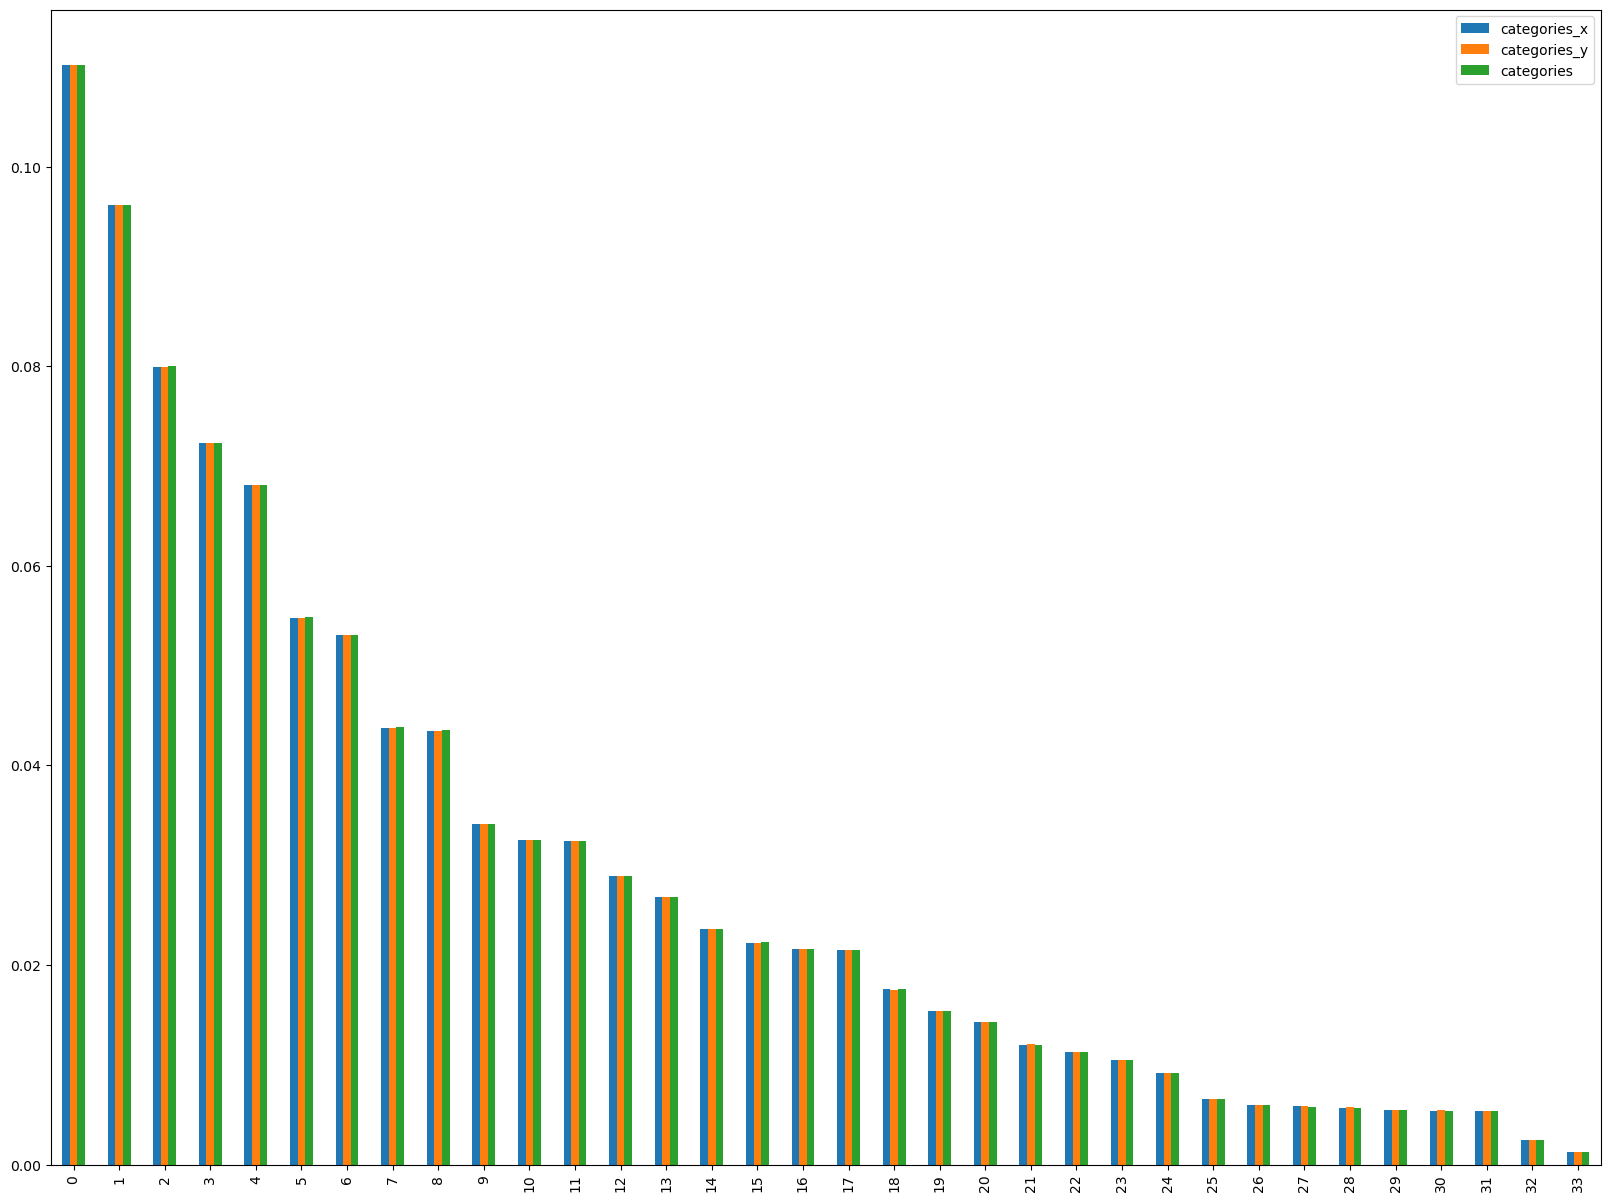

In [9]:
mark_distrib.plot(kind="bar", figsize=(20,15))

In [10]:
X_test.sample(5)

,text,categories,embedding (Bert+MP),embedding (Bert+MP+class-arx),embedding (Bert+MP+class-zbm),embedding (Mathbert+CLS),embedding (Mathbert+MP+class-arx),embedding (Mathbert+MP+class-zbm),embedding (Bert+TSDAE+MP),embedding (Bert+TSDAE+MP+class-arx),...,embedding (Specter 2+MP),embedding (Specter 2.0+MP+class-arx),embedding (Specter 2.0+MP+class-zbm),embedding (Specter 2+MP+class-zbm+anch-arx),embedding (Specter 2+MP+anch-arx+class-arx+class-zbm),embedding (SGPT),embedding (SGPT+class-zbm),embedding (SGPT+class-arx),title,abstract
13784,Clifford Algebras and Graphs. I show how to as...,math.CO,"[-0.07277816, 0.27007422, 0.07593504, -0.11568...","[0.5213126, -0.12090416, -0.053986333, 0.40462...","[0.74372005, 0.17599592, 0.608528, 0.535915, -...","[-0.032980457, 0.024657108, 0.01885785, -0.019...","[0.20031384, 0.6470317, 0.56421167, 0.9379395,...","[-1.4476402, -0.66179353, 0.45928615, -0.34104...","[0.4123196, 0.6722223, -0.086386435, -0.103253...","[-0.7290086, -0.40107322, 0.13590063, -0.21437...",...,"[-0.11903504, 0.35993928, 0.15627249, 0.207749...","[0.5493879, 1.3436564, 1.6488031, -0.0698862, ...","[0.83108824, 1.2523887, 0.36735576, 0.24590974...","[1.2692542, 1.0818927, 0.27894378, 0.50803244,...","[0.9156246, 1.1736181, 1.0134802, -0.040511765...","[0.3196472, -3.7126083, 0.48860556, -0.7478444...","[0.46029922, -1.0036471, 0.3213928, 0.00352051...","[0.3288018, -1.188343, 0.69398105, 2.1528418, ...",Clifford Algebras and Graphs,I show how to associate a Clifford algebra t...
23291,Enumeration of strictly Deza graphs with at mo...,math.CO,"[-0.14465536, 0.04871592, 0.47901848, -0.25022...","[1.2097667, 1.4285192, -0.27049014, -0.1551754...","[-0.056141723, 0.9088687, -0.023038602, -0.587...","[-0.038036406, 0.015640281, 0.0152276065, -0.0...","[-0.21517767, 0.66958314, -0.67615783, -0.0173...","[0.5813982, -0.21109663, -0.5278558, 1.2385216...","[-0.19119495, 0.117722526, 0.2190268, 0.036176...","[0.028894626, 0.814705, -0.097664334, -0.32737...",...,"[0.39399132, 0.3669832, 0.055519834, 0.292523,...","[-0.3756054, -0.29433116, 0.09735349, 0.230950...","[0.28341496, 2.6760893, 0.28798932, 2.143349, ...","[-0.6741576, 1.319661, 0.768559, -0.21196029, ...","[-0.6133655, -0.6212625, -0.3820062, 0.9159640...","[0.63916886, -0.5916624, -0.27639922, -0.95098...","[0.744057, -0.13601352, 0.8297725, 0.12274643,...","[0.93533784, -0.18259965, 1.7401689, 2.4779317...",Enumeration of strictly Deza graphs with at mo...,"A Deza graph $\Gamma$ with parameters $(v,k,..."
1834,Local discontinuous Galerkin methods for the t...,math.NA,"[-0.38762823, -0.08139185, 0.5251901, -0.20111...","[-0.8471416, 0.29065058, 0.6541644, 0.33612254...","[-0.48782882, 0.2908365, -0.67047274, -0.23036...","[-0.030022237, 0.052551027, 0.046698533, -0.01...","[-0.20355469, 0.3849206, -0.5665844, -0.737442...","[-0.07538148, 0.33806434, 1.3983532, -0.160792...","[-0.1253268, 0.05382247, 0.37875095, 0.0294586...","[-0.53379345, 0.2063679, 1.7773287, -0.9085870...",...,"[0.23579367, 0.044534937, 0.5479531, 0.4249054...","[-0.3757087, -0.14162822, 1.6748405, 1.0325264...","[-0.09372345, -0.7995557, 1.0278146, 1.1482526...","[-0.8150705, -1.0125486, 0.8075675, 0.68275756...","[-1.2214898, 0.35596013, 1.9378453, 1.9258833,...","[-0.986226, -0.93417645, -0.08274859, -0.89024...","[0.110269755, 0.1208273, 0.32953098, -1.290072...","[1.4551464, -1.034554, 0.1067161, -2.220529, -...",Local discontinuous Galerkin methods for the t...,"In this article, we consider discrete scheme..."
12545,Reverse Mathematics and Recursive Graph Theory...,math.LO,"[-0.20461959, 0.17531067, 0.073607914, -0.0897...","[1.2473276, 1.4913204, -0.14616913, -0.1226727...","[0.2896762, 0.6139451, 0.031909592, -0.3349367...","[0.0028936632, 0.025593739, 0.0015963743, 0.00...","[0.07919355, 0.5423289, -0.64416593, 0.2525754...","[-0.044694252, -0.6750367, -0.6444782, 0.25182...","[0.10968746, 0.36551797, -0.32418728, 0.117805...","[0.3166926, 0.88520366, -0.19114128, -0.566070...",...,"

In [11]:
# Prerequisites for the models
bert_base = models.Transformer('bert-base-uncased')
bert_mp = SentenceTransformer(modules=[bert_base, models.Pooling(bert_base.get_word_embedding_dimension())])

mathbert_base = models.Transformer('witiko/mathberta')
mathbert_mp = SentenceTransformer(modules=[mathbert_base, models.Pooling(mathbert_base.get_word_embedding_dimension())])
mathbert_cls = SentenceTransformer(modules=[mathbert_base, models.Pooling(mathbert_base.get_word_embedding_dimension(), pooling_mode="cls")])

bert_mlm_base = models.Transformer("./bert+re-train_mlm_abstracts_arxiv")
bert_mlm_mp = SentenceTransformer(modules=[bert_mlm_base, models.Pooling(bert_mlm_base.get_word_embedding_dimension())])

sbert = SentenceTransformer('all-mpnet-base-v2')
# alternative: sbert = SentenceTransformer('all-distilroberta-v1')

specter2_base = models.Transformer('allenai/specter2_base')

# Definition of models that are evaluated
# combine models into dict
eval_models = {
    "Bert+MP": bert_mp,
    "Bert+MP+class-arx": SentenceTransformer('./bert+mean-pooling+retrain_class_arxiv'),
    "Bert+MP+class-zbm": SentenceTransformer('./bert+mean-pooling+retrain_class_zbmath'),
    
    "Mathbert+CLS": mathbert_cls,
    "Mathbert+MP+class-arx": SentenceTransformer('./mathbert+mean-pooling+retrain_class_arxiv'),
    "Mathbert+MP+class-zbm": SentenceTransformer('./mathbert+mean-pooling+retrain_class_zbmath'),
    
    "Bert+TSDAE+MP": SentenceTransformer('./bert+mean-pooling+re-train_tsdae_abstracts_arxiv'),
    "Bert+TSDAE+MP+class-arx": SentenceTransformer('./bert+mean-pooling+re-train_tsdae_abstracts_arxiv+retrain_class_arxiv'),
    "Bert+TSDAE+MP+class-zbm": SentenceTransformer('./bert+mean-pooling+re-train_tsdae_abstracts_arxiv+retrain_class_zbmath'),
    
    "Bert+MLM+MP": bert_mlm_mp,
    "Bert+MLM+MP+class-arx": SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_class_arxiv'),
    "Bert+MLM+MP+class-zbm": SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_class_zbmath'),
    "Bert+MLM+MP+class-zbm+anch-arx": SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_class_zbmath_anchor_arxiv'),
    "Bert+MLM+MP+class-arx+anch-arx+class-zbm": SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_class_arxiv_anchor_arxiv_class_zbmath'),
    
    "SBert": sbert,
    "SBert+ret_class-arx": SentenceTransformer('./sbert+retrain_class_arxiv'),
    "SBert+ret_class-zbm": SentenceTransformer('./sbert+retrain_class_zbmath'),
    
    "Specter 2+MP": SentenceTransformer(modules=[specter2_base, models.Pooling(specter2_base.get_word_embedding_dimension())]),
    "Specter 2.0+MP+class-arx": SentenceTransformer('./specter2+mp+retrain_class_arxiv'),
    "Specter 2.0+MP+class-zbm": SentenceTransformer('./specter2+mp+retrain_class_zbmath'),
    "Specter 2+MP+class-zbm+anch-arx": SentenceTransformer('./specter2+mp+retrain_class_zbmath_anchor_arxiv'),
    "Specter 2+MP+anch-arx+class-arx+class-zbm": SentenceTransformer('./specter2+mp+retrain_anchor_arxiv_class_arxiv_class_zbmath'),
    
    "SGPT": SentenceTransformer('Muennighoff/SGPT-125M-weightedmean-nli-bitfit'),
    "SGPT+class-arx": SentenceTransformer('./gpt+retrain_class_arxiv'),
    "SGPT+class-zbm": SentenceTransformer('./gpt+retrain_class_zbmath'),
}

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at witiko/mathberta were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight'

In [12]:
# Reduce text to first sentence aka title

X_test["abstract"] = X_test["abstract"].map(lambda c: "{}.".format(random.choice(nltk.data.load('tokenizers/punkt/PY3/english.pickle').tokenize(c))).strip())
X_eval["abstract"] = X_eval["abstract"].map(lambda c: "{}.".format(random.choice(nltk.data.load('tokenizers/punkt/PY3/english.pickle').tokenize(c))).strip())

#X_test["abstract"] = X_test["title"]
#X_eval["abstract"] = X_eval["title"]

In [13]:
%%time

with tqdm(total=len(eval_models), desc="Models") as pb:
    for n,m in eval_models.items():
        X_test["embedding ({})".format(n)] = pd.Series(list(simi.model_embeddings(m, X_test["abstract"], show_progress_bar=True)))
        X_eval["embedding ({})".format(n)] = pd.Series(list(simi.model_embeddings(m, X_eval["abstract"], show_progress_bar=True)))
        pb.update()

Models:   0%|          | 0/25 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

Batches:   0%|          | 0/851 [00:00<?, ?it/s]

CPU times: user 3h 3min 23s, sys: 8min 31s, total: 3h 11min 55s
Wall time: 43min 59s


In [14]:
def suggest(eval_models, corpus, queries, device="cuda:0", msc_col="MSC", **search_args):
    msc_sug = pd.DataFrame()
    with tqdm(total=len(eval_models), desc="Models") as pb:
        for n,m in eval_models.items():
            c = torch.stack([torch.tensor(v) for v in corpus["{} ({})".format("embedding", n)].values])
            c.to(device)
            c = stu.normalize_embeddings(c)
            
            q = torch.stack([torch.tensor(v) for v in queries["{} ({})".format("embedding", n)].values])
            q.to(device)
            q = stu.normalize_embeddings(q)
            
            idxs = pd.Series([[r["corpus_id"] for r in res] for res in stu.semantic_search(q, c, score_function=stu.dot_score, **search_args)])
            msc_sug["{} ({})".format(msc_col, n)] = idxs.map(lambda e: corpus.loc[e][msc_col].values)

            pb.update()
    msc_sug.index = queries.index
    return msc_sug

In [15]:
%%time
X_test = X_test.join(suggest(eval_models, X_train, X_test, device="cuda:0", msc_col="categories", top_k=200, query_chunk_size=5000, corpus_chunk_size=250000))
X_test.to_pickle("arxiv-random-sentence-200-recommendations-single-class-multi-test.pkl")

Models:   0%|          | 0/25 [00:00<?, ?it/s]

CPU times: user 49min 6s, sys: 8min 55s, total: 58min 1s
Wall time: 10min 36s


In [16]:
X_test.sample(5)

,text,categories,embedding (Bert+MP),embedding (Bert+MP+class-arx),embedding (Bert+MP+class-zbm),embedding (Mathbert+CLS),embedding (Mathbert+MP+class-arx),embedding (Mathbert+MP+class-zbm),embedding (Bert+TSDAE+MP),embedding (Bert+TSDAE+MP+class-arx),...,categories (SBert+ret_class-arx),categories (SBert+ret_class-zbm),categories (Specter 2+MP),categories (Specter 2.0+MP+class-arx),categories (Specter 2.0+MP+class-zbm),categories (Specter 2+MP+class-zbm+anch-arx),categories (Specter 2+MP+anch-arx+class-arx+class-zbm),categories (SGPT),categories (SGPT+class-arx),categories (SGPT+class-zbm)
24149,Independence of higher Kurepa hypotheses. We s...,math.LO,"[-0.2459707, -0.23394859, -0.061279375, -0.288...","[-0.22480346, 0.8624776, -0.12377156, -0.33779...","[-0.9205697, 1.3152132, -0.5148326, -0.1191336...","[-0.03839203, 0.019338127, -0.01851523, 0.0021...","[0.57932055, -0.26235735, -0.066513926, 0.7969...","[0.6095671, 0.26683173, -0.704108, -0.38697585...","[-0.21798046, 0.16314852, -0.44455475, 0.19798...","[0.06313467, 0.851435, -0.2947041, -0.3382268,...",...,"[math.LO, math.MG, math.LO, math.GM, math.LO, ...","[math.CO, math.GM, math.CO, math.CO, math.FA, ...","[math.GR, math.RT, math.NT, math.OA, math.GR, ...","[math.HO, math.AG, math.CA, math.HO, math.GN, ...","[math.CA, math.NT, math.PR, math.CA, math.CO, ...","[math.GR, math.AG, math.RA, math.DG, math.DS, ...","[math.AG, math.KT, math.DS, math.RA, math.DS, ...","[math.LO, math.GN, math.CA, math.AG, math.NA, ...","[math.FA, math.LO, math.FA, math.LO, math.HO, ...","[math.AG, math.AC, math.FA, math.LO, math.LO, ..."
2890,Relative Northcott numbers for the weighted We...,math.NT,"[-0.21171728, -0.11126867, 0.135446, -0.218159...","[0.070590794, 0.5828134, -0.02778898, -0.08630...","[-0.41519994, 0.8520552, 0.7830598, 0.21872525...","[-0.011005379, 0.025626877, -0.008282234, -0.0...","[0.69154894, 0.54102504, -0.32355973, -0.54586...","[-0.08883534, -0.6538237, 0.20860088, -0.20169...","[-0.3814055, 0.3939914, -0.05601106, -0.003615...","[-0.35912618, 0.6746786, -0.35989103, -0.68143...",...,"[math.NT, math.NT, math.GM, math.NT, math.GM, ...","[math.NT, math.CA, math.RT, math.GR, math.AC, ...","[math.NT, math.NT, math.NT, math.AG, math.GT, ...","[math.NT, math.GM, math.NT, math.NT, math.NT, ...","[math.NT, math.NT, math.NT, math.NT, math.NT, ...","[math.NT, math.AT, math.AG, math.AT, math.AG, ...","[math.KT, math.NT, math.NT, math.NT, math.GM, ...","[math.NT, math.AG, math.NT, math.AT, math.NT, ...","[math.CA, math.FA, math.CA, math.AG, math.CV, ...","[math.NT, math.NT, math.AG, math.DG, math.NT, ..."
13564,Critical functions on Riemannian Manifold wich...,math.AP,"[-0.34169474, -0.32780752, 0.4258624, -0.14769...","[-0.6009824, -0.48152113, 1.5008491, 0.1911167...","[-0.3133079, 1.0892462, 0.89463997, -0.1259445...","[-0.03591236, 0.013176955, -0.01711843, -0.002...","[0.27602875, 0.9295469, 0.12252608, 0.40426356...","[0.6822658, -0.9103755, 0.1437287, -0.84453976...","[-0.24948044, -0.04303408, 0.23275737, -0.2520...","[-0.30070257, 0.072411515, 1.2975775, -0.58158...",...,"[math.DG, math.DG, math.DG, math.DG, math.DG, ...","[math.DG, math.CV, math.DG, math.DG, math.DG, ...","[math.DG, math.DG, math.DS, math.DG, math.DG, ...","[math.OC, math.CA, math.CA, math.AP, math.CA, ...","[math.DG, math.OC, math.FA, math.FA, math.CA, ...","[math.CV, math.CV, math.AP, math.FA, math.DG, ...","[math.CV, math.AP, math.OC, math.CV, math.AP, ...","[math.DG, math.DG, math.DG, math.DG, math.DG, ...","[math.DG, math.AP, math.DG, math.DG, math.DG, ...","[math.DG, math.DG, math.DG, math.MG, math.MG, ..."
4110,Kinetic Modelling of Colonies of Myxobacteria....,math.AP,"[-0.15373248, 0.024055313, 0.23656088, -0.2367...","[-0.5074581, -0.6902995, 0.97480756, 0.4953183...","[-0.004079911, 0.86188924, 0.5006996, -0.29573...","[-0.030092008, 0.03302087, -0.01253179, 0.0103...","[0.031160792, 0.67832965, 0.24440652, 0.255127...","[-0.16532837, 0.44673342, -0.7312756, 1.363991...","[0.36609444, 0.

In [18]:
del X_test

In [19]:
%%time
X_eval = X_eval.join(suggest(eval_models, X_train, X_eval, device="cuda:0", msc_col="categories", top_k=200, query_chunk_size=5000, corpus_chunk_size=250000))
X_eval.to_pickle("arxiv-random-sentence-200-recommendations-single-class-multi-eval.pkl")
del X_eval

Models:   0%|          | 0/25 [00:00<?, ?it/s]

CPU times: user 51min 4s, sys: 19min 11s, total: 1h 10min 16s
Wall time: 11min 51s
